# Read in the data

In [24]:
import pandas as pd
import numpy
import re

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv',
]
data = {}

for f in data_files:
    key_name = f.replace('.csv', '')
    d = pd.read_csv(f'schools/{f}')
    data[key_name] = d

# Read in the surveys

In [25]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN',
    'rr_s',
    'rr_t',
    'rr_p',
    'N_s',
    'N_t',
    'N_p',
    'saf_p_11',
    'com_p_11',
    'eng_p_11',
    'aca_p_11',
    'saf_t_11',
    'com_t_11',
    'eng_t_11',
    'aca_t_11',
    'saf_s_11',
    'com_s_11',
    'eng_s_11',
    'aca_s_11',
    'saf_tot_11',
    'com_tot_11',
    'eng_tot_11',
    'aca_tot_11',
]
survey = survey[survey_fields]
data['survey'] = survey

# Add DBN columns

In [26]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']


def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation


data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric

In [27]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = (
    data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
)


def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat


def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon


data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

<>:11: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
I:\Temp\ipykernel_29276\1145006712.py:11: SyntaxWarning: invalid escape sequence '\('
  coords = re.findall('\(.+, .+\)', loc)
I:\Temp\ipykernel_29276\1145006712.py:17: SyntaxWarning: invalid escape sequence '\('
  coords = re.findall('\(.+, .+\)', loc)


# Condense datasets

In [28]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size = class_size.groupby('DBN').agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

# Convert AP scores to numeric

In [29]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

# Combine the datasets

In [30]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [31]:
def get_first_two_chars(dbn):
    return dbn[0:2]


combined = combined.copy()
combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

# Find correlations

In [32]:
correlations = combined.corr(numeric_only=True)
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [33]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

# Survey Fields vs SAT Score

In [34]:
sat_corr = {}

for s in survey_fields:
    sat_corr[s] = combined['sat_score'].corr(combined[s])

print(sat_corr)

{'rr_s': np.float64(0.2321991292751196), 'rr_t': np.float64(-0.02338629117346636), 'rr_p': np.float64(0.047924518831984356), 'N_s': np.float64(0.423462947509197), 'N_t': np.float64(0.2914630275178502), 'N_p': np.float64(0.42153002535808953), 'saf_p_11': np.float64(0.12291283627180781), 'com_p_11': np.float64(-0.11507348242782607), 'eng_p_11': np.float64(0.020254107222305914), 'aca_p_11': np.float64(0.03515461800865577), 'saf_t_11': np.float64(0.31381033335201014), 'com_t_11': np.float64(0.08241941890129453), 'eng_t_11': np.float64(0.03690647858376121), 'aca_t_11': np.float64(0.13234766778256463), 'saf_s_11': np.float64(0.3376387443608815), 'com_s_11': np.float64(0.18737020184780123), 'eng_s_11': np.float64(0.21382160813472625), 'aca_s_11': np.float64(0.33943547354225334), 'saf_tot_11': np.float64(0.31875345021709883), 'com_tot_11': np.float64(0.07731020128970859), 'eng_tot_11': np.float64(0.10010182962480557), 'aca_tot_11': np.float64(0.19096597794093298)}


In [35]:
sat_corr_df = pd.DataFrame.from_dict(sat_corr, orient='index')

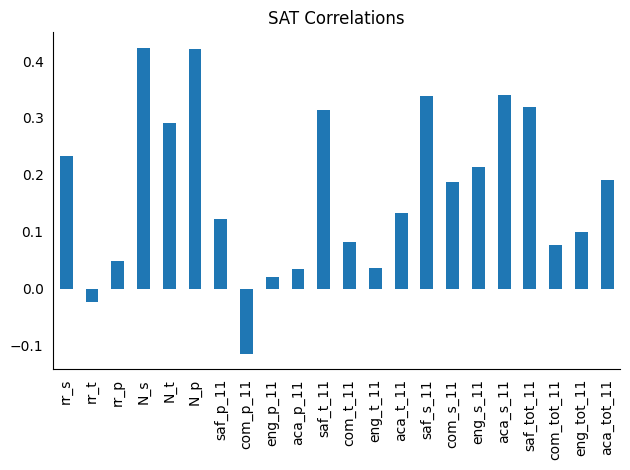

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sat_corr_df.plot.bar(legend=False)
plt.title('SAT Correlations')
plt.tick_params(left=False, bottom=False)

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/sat_corr.png')
plt.show()

## Interesting Correlations:
- `N_s`: Number of student respondents (~0.4)
- `N_t`: Number of teacher respondents (~0.3)
- `N_p`: Number of parent respondents (~0.4)
- `saf_t_11`: Safety and Respect score based on teacher responses (~0.3)
- `saf_s_11`: Safety and Respect score based on student responses (~0.3)
- `aca_s_11`: Academic expectations score based on student responses (~0.3)
- `saf_tot_11`: Safety and Respect total score (~0.3)

# Investigate Safety Scores

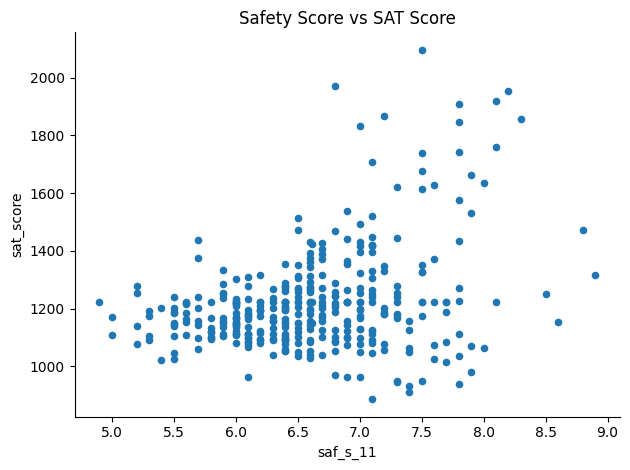

In [37]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

plt.title('Safety Score vs SAT Score')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/safety_vs_sat.png')
plt.show()

## Conclusions Drawn:
- There is a slightly positive correlation in which safer schools achieve higher SAT scores

# Compute Average Safety Score Per Borough

In [38]:
# Group by borough, aggregate the mean, and sort by highest safety score to lowest
avg_safety_per_borough = (
    combined[['boro', 'saf_s_11']]
    .groupby('boro')
    .agg('mean', numeric_only=True)
    .sort_values('saf_s_11', ascending=False)
)
avg_safety_per_borough

,saf_s_11
boro,
Manhattan,6.831370
Queens,6.721875
Bronx,6.606577
Staten Island,6.530000
Brooklyn,6.370755


## Conclusions Drawn:
- Northern boroughs are generally more safer than those located towards the South
- Manhattan leads with the highest safety score (6.83)
- Brooklyn scores the lowest safety score (6.37)

# Investigate Race vs SAT Scores

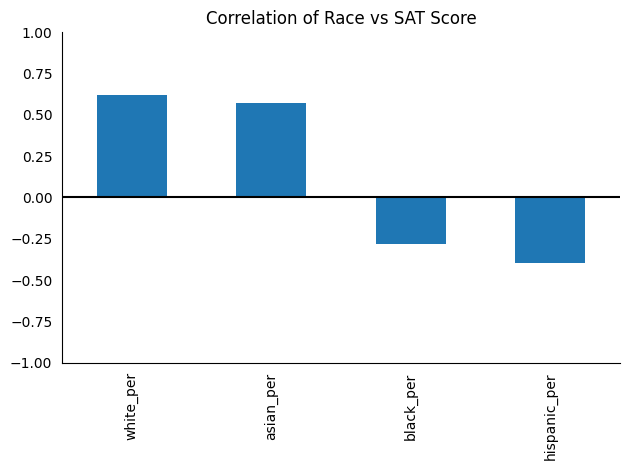

In [39]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr(numeric_only=True)['sat_score'][race_cols].plot.bar()

plt.title('Correlation of Race vs SAT Score')

plt.ylim(-1, 1)

plt.tick_params(left=False, bottom=False)

plt.axhline(0, color='black')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/race_vs_sat.png')
plt.show()

## Conclusions Drawn:
- Schools with higher proportions of white and asian race students exhibit a positively correlated higher SAT score
- Schools with higher proportions of black and hispanic race students exhibit a negatively correlated lower SAT score

# Investigate `hispanic_per`

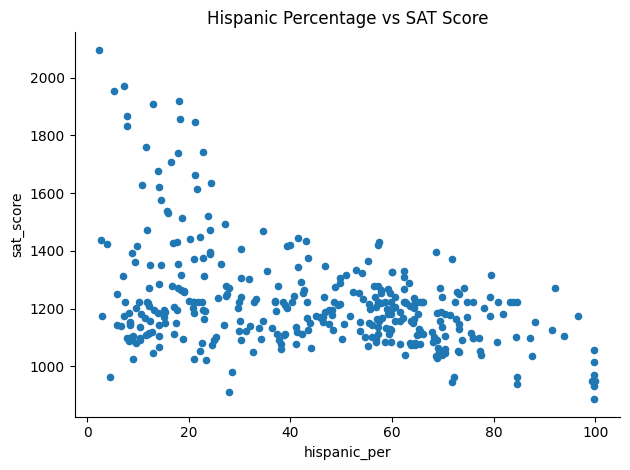

In [40]:
# Scatter Plot for `hispanic_per` and `sat_score`

combined.plot.scatter(x='hispanic_per', y='sat_score')

plt.title('Hispanic Percentage vs SAT Score')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/hispanic_vs_sat.png')
plt.show()

## Findings:
- The scatter plot shows a negatively correlated SAT score per higher hispanic percentages
- Max `sat_score` lowers significantly towards ~30% hispanic percentage schools, with it eventually tapering off downwards slightly to a max of ~1100 at the tail-end.
- Lower-end `sat_score` entries remain relatively consistent throughout hispanic percentages, with a general score of around 1000
- A majority of data points lie within 1000-1400 SAT score

In [41]:
# Find schools with `hispanic_per` greater than 95%

combined[combined['hispanic_per'] > 95]['school_name']

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

## Findings:
- Public schools
- Some schools (e.g. Pan American International High School at Monroe) are for Latino immigrants only
- Manhattan, Brooklyn, and The Bronx boroughs

In [42]:
# Schools with less than 10% `hispanic_per` and higher than 1800 sat_score

combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

## Findings:
- Also public schools
- More technically-inclined schools (preparatory, specialized)
- More diverse location-wise (one from each borough)

# Investigate Gender and SAT Scores

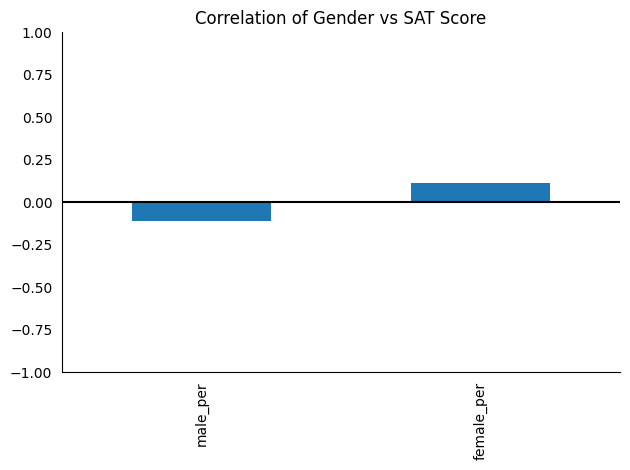

In [43]:
# Correlations between `sat_score` and `male_per`/`female_per`
gender_corr = combined.corr(numeric_only=True)['sat_score'][['male_per', 'female_per']].plot.bar()

plt.title('Correlation of Gender vs SAT Score')

plt.ylim(-1, 1)

plt.tick_params(left=False, bottom=False)

plt.axhline(0, color='black')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/gender_vs_sat.png')
plt.show()

## Findings:
- Slight negative correlation for higher male proportion schools (around -0.12)
- Slight positive correlation for higher female proportion schools (around 0.12)

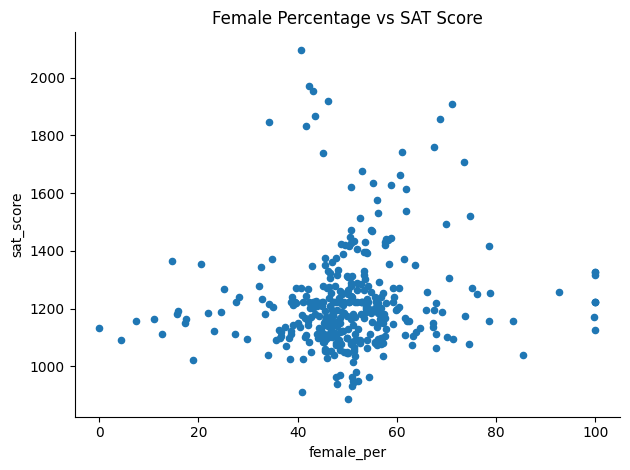

In [44]:
# Scatter plot of female_per and sat_score

combined.plot.scatter(x='female_per', y='sat_score')

plt.title('Female Percentage vs SAT Score')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/female_vs_sat.png')
plt.show()

## Findings:
- No significant correlation between variables `female_per` and `sat_score`
- Most data points are within 40-60% female populated schools
- Most variation also occurs within 40-60% female range

In [45]:
# Schools with more than 60% female and higher than 1700 sat score

combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

## Findings:
- Low student counts for multiple schools
- Prep schools and highly technical schools
- Highly competitive (low acceptance rate amongst high number of applicants)